In [233]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

from scipy.stats import f_oneway
import seaborn as sns
import numpy as np
import dython
import shapefile as shp

sns.set_style("whitegrid")
sns.color_palette(palette='pastel') 

sns.mpl.rc("figure",figsize=(10,6))

In [234]:
# the path to csv file directory
mycsvdir = '/home/sammich/Documents/BeCode/becode_projects/real-estate-price-prediction/data files/good_csv_files/good csv files'
print(mycsvdir)
# get all the csv files in that directory (assuming they have the extension .csv)
csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

# loop through the files and read them in with pandas
dataframes = []  # a list to hold all the individual pandas DataFrames
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    dataframes.append(df)

# concatenate them all together
result = pd.concat(dataframes, ignore_index=True)

# print out to a new csv file
result.to_csv('csv6to14.csv')

/home/sammich/Documents/BeCode/becode_projects/real-estate-price-prediction/data files/good_csv_files/good csv files


In [235]:
all_datadf=pd.read_csv('./csv6to14.csv')


all_datadf['price']=pd.to_numeric(all_datadf['price'], errors='coerce')
all_datadf=all_datadf.fillna(0)
all_datadf=all_datadf.iloc[:, 2:]
all_datadf=all_datadf.drop_duplicates()

/tmp/ipykernel_4348/2218926366.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  all_datadf=pd.read_csv('./csv6to14.csv')


In [236]:
#remove outliers function
def remove_outliers(df,columns,n_std):
    for col in columns:
        #print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
    print(str(round(mean,2)) + ', ' +  str(round(sd,2)))
    #print(df[col] <= mean+(n_std*sd))    
    return df

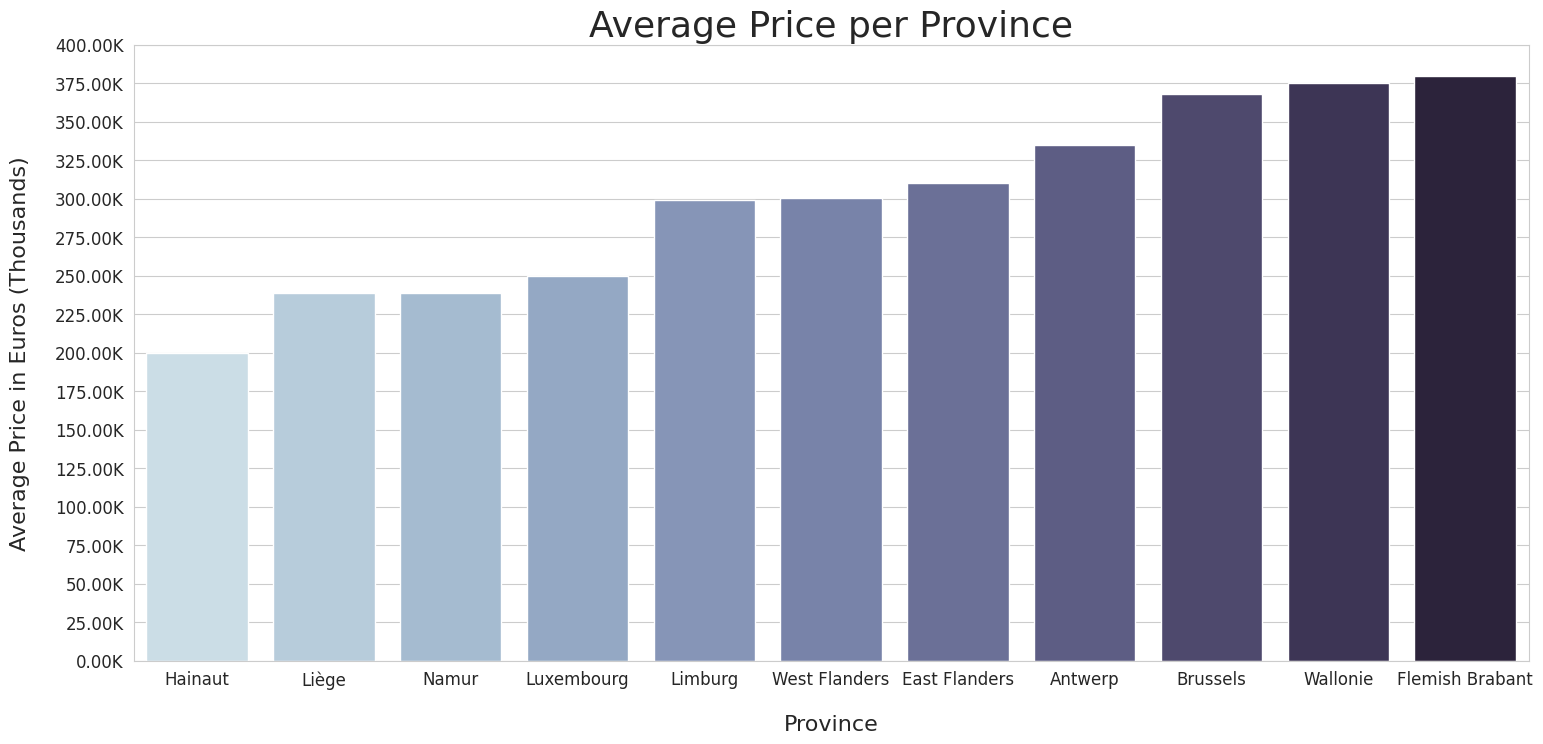

In [246]:
#Make bar chart for price by province

all_datadf['price']=all_datadf['price'].astype(int)
all_datadf=all_datadf[all_datadf['price'] > 0]


#groupby province and sort the prices
provincepricedf=all_datadf.groupby(['province'], as_index=False)['price'].median()
sortedprovincepricedf=provincepricedf.sort_values('price')
all_datadf=all_datadf.replace(to_replace='Walloon Brabant', value='Wallonie')

#start plotting
fig, ax = plt.subplots(figsize=(18, 8))
province_price_bar=sns.barplot(ax=ax, data = sortedprovincepricedf , x= 'province', y = 'price', palette="ch:s=.25,rot=-.25");
width=0.2
province_price_bar.set_title('Average Price per Province', fontdict={'fontsize' : 26})
province_price_bar.set_xlabel('Province', fontdict={'fontsize':16}, labelpad=18)

province_price_bar.set_ylabel('Average Price in Euros (Thousands)', fontdict={'fontsize':16}, labelpad=18)
province_price_bar.set_yticks(range(0,425000, 25000))
ylabels = ['{:,.2f}'.format(y) + 'K' for y in province_price_bar.get_yticks()/1000]
province_price_bar.set_yticklabels(ylabels)

province_price_bar.tick_params(axis='both', which='major', labelsize=12)


319099.72, 125674.57
[1970, 3210, 8300, 4720, 1950, 1640, 2970, 2960, 2330, 1820]


[Text(0, 500000, '500.00K'),
 Text(0, 550000, '550.00K'),
 Text(0, 600000, '600.00K'),
 Text(0, 650000, '650.00K'),
 Text(0, 700000, '700.00K'),
 Text(0, 750000, '750.00K'),
 Text(0, 800000, '800.00K'),
 Text(0, 850000, '850.00K'),
 Text(0, 900000, '900.00K'),
 Text(0, 950000, '950.00K'),
 Text(0, 1000000, '1,000.00K'),
 Text(0, 1050000, '1,050.00K')]

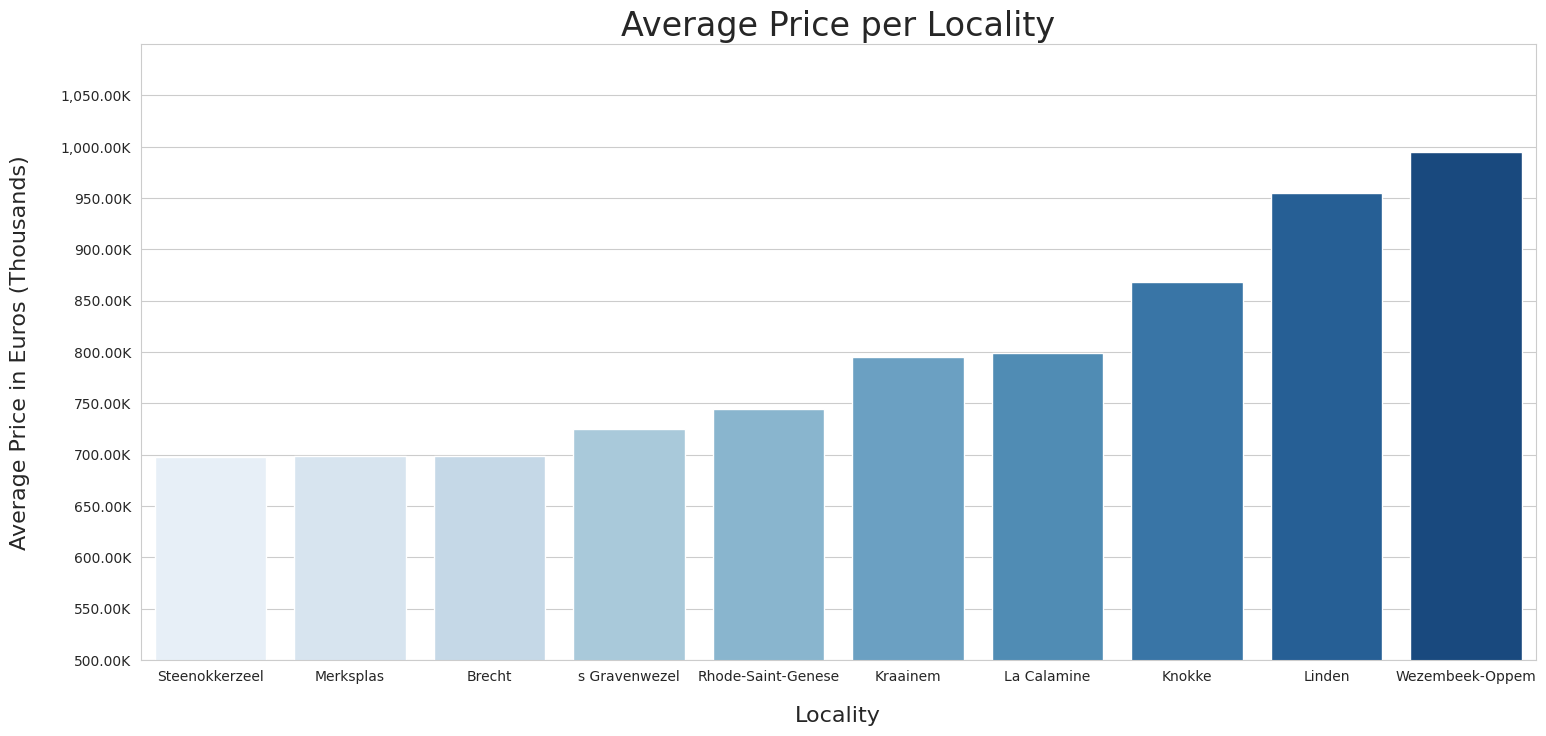

In [260]:

all_datadf['postalCode']=all_datadf['postalCode'] // 10 * 10
postalCodes=all_datadf['postalCode'].unique()

result=all_datadf.groupby('postalCode')['price'].aggregate(['min', 'mean', 'max', 'std'])

avg_price_postalcodes=all_datadf.groupby(['postalCode'], as_index=False)['price'].median()
stdev_price_postalcodes=all_datadf.groupby(['postalCode'], as_index=False)['price'].std()

avg_price_postalcodes=remove_outliers(avg_price_postalcodes, ['price'], 6)


sortedrich=avg_price_postalcodes.sort_values(by='price', ascending=False)

rich10=sortedrich.iloc[0:10]
richlist=list(rich10['postalCode'])
print(richlist)

rich10localities={1970 : 'Wezembeek-Oppem', 3210 : 'Linden', 8300 : 'Knokke', 4720: 'La Calamine',
 1950 : 'Kraainem', 1640 : 'Rhode-Saint-Genese', 2970 : 's Gravenwezel', 2960 : 'Brecht', 2330 : 'Merksplas', 1820: 'Steenokkerzeel'}
rich10locality=rich10.replace({'postalCode' : rich10localities})
#rich10=rich10.replace({'locality':{'BRUXELLES 18' : 'Molenbeek', 'Bruxelles' : 'Schaarbeek', '8300' : 'Knokke'} })
sortedrich10locality=rich10locality.sort_values('price')

fig, ax = plt.subplots(figsize=(18, 8))

localpricebarplot=sns.barplot(data = sortedrich10locality , x = 'postalCode', y = 'price' , errorbar= 'sd', palette="Blues")

#localpricebarplot.set_title('Localities with highest Prices', fontdict={'fontsize' : 26})


localpricebarplot.set_title('Average Price per Locality', fontdict= {'fontsize':24})

localpricebarplot.set_xlabel( 'Locality', fontdict= {'fontsize': 16}, labelpad=16)
#localpricebarplot.set_ylabel('Price (Millions Euros)', fontdict= {'fontsize': 16}, labelpad=16)
localpricebarplot.set_ylim(bottom=600000, top=1100000)
localpricebarplot.set_yticks(range(500000,1100000, 50000))
ax.set_ylabel('Average Price in Euros (Thousands)', fontdict={'fontsize':16}, labelpad=22)
ylabels = ['{:,.2f}'.format(y) + 'K' for y in localpricebarplot.get_yticks()/1000]
localpricebarplot.set_yticklabels(ylabels)
#yax2=ax.twiny()
#plt.yticks([600000, 700000, 800000, 900000, 1000000])


In [238]:
all_datadf['surfaceAreaOfPlot']=all_datadf['surfaceAreaOfPlot'].astype(int)

#reduce the surface area outliers
all_datadf=all_datadf[all_datadf['surfaceAreaOfPlot'] < 100000]

interestcolumns = ['surfaceAreaOfPlot']
all_datadf=remove_outliers(all_datadf, interestcolumns, 1)

#sns.lineplot(data = all_datadf, x = 'surfaceAreaOfPlot', y = 'price')
#plt.show()

589.27, 2790.01


/tmp/ipykernel_4348/347565840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interestingdf['postalCode']=interestingdf['postalCode'].astype(str)


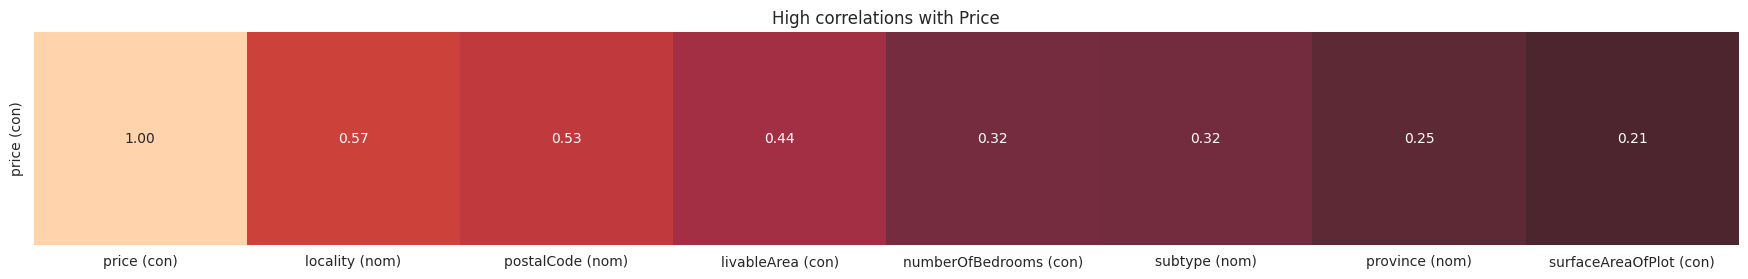

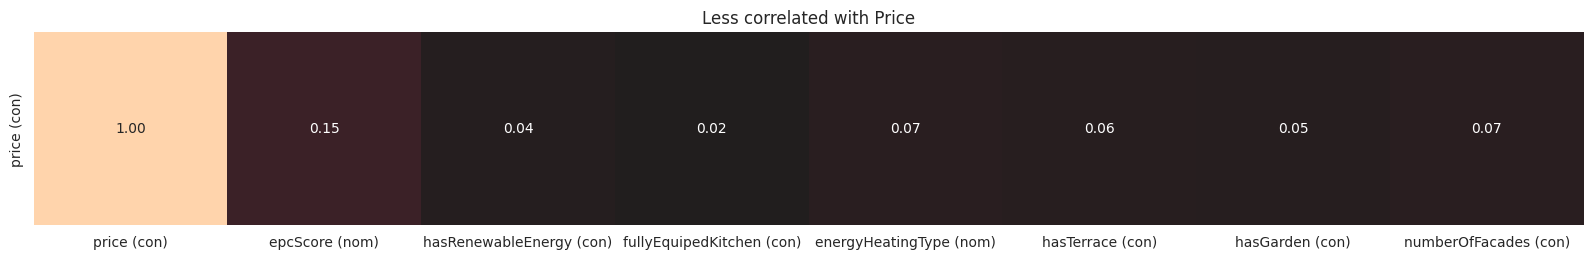

{'corr':              price (con)  epcScore (nom)  hasRenewableEnergy (con)  \
 price (con)          1.0        0.146345                  0.039267   
 
              fullyEquipedKitchen (con)  energyHeatingType (nom)  \
 price (con)                   0.018777                   0.0669   
 
              hasTerrace (con)  hasGarden (con)  numberOfFacades (con)  
 price (con)          0.056086         0.053117               0.069031  ,
 'ax': <AxesSubplot:title={'center':'Less correlated with Price'}>}

In [261]:
#check correlations with prices

from dython import nominal

#correlation_ratio=0.8
interestingdf=all_datadf[['price', 'locality', 'postalCode', 'livableArea', 'numberOfBedrooms', 'subtype', 'province', 'surfaceAreaOfPlot']]
maybeinterestingdf=all_datadf[['price', 'epcScore','hasRenewableEnergy', 'fullyEquipedKitchen', 'energyHeatingType', 'hasTerrace', 'hasGarden', 'numberOfFacades' ]]
interestingdf['postalCode']=interestingdf['postalCode'].astype(str)
fig, ax = plt.subplots(figsize=(22, 8))

nominal.associations(interestingdf,figsize=(20,20), mark_columns=True, display_rows = ['price'], cbar=False, title="High correlations with Price", ax=ax )
nominal.associations(maybeinterestingdf, figsize=(20,10), mark_columns=True, display_rows=['price'], cbar=False, title="Less correlated with Price")

